In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
import torch.nn as nn
import random
import sys
import os

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [4]:
experiment_num = 8

In [5]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
# with h5py.File('../../data/3d_array/test_data_3d_h5.h5', 'r') as f:
#     test_X = f['test_data_3d'][:]

train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')

In [6]:
train_X = np.nan_to_num(train_X, nan = 0)
val_X = np.nan_to_num(val_X, nan = 0)

In [7]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [8]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_13780\639591509.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_13780\639591509.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]


In [9]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [10]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [11]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=True, dropout=0.3):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2) if pool else None
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        if self.pool:
            x = self.pool(x)
        x = self.dropout(x)
        return x

In [13]:
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(ConvModel, self).__init__()
        
        # First convolutional block
        self.block1 = ConvBlock(input_size, 16, dropout=0)
        
        # Second convolutional block
        self.block2 = ConvBlock(16, 32, dropout=0)
        
        # Third convolutional block
        self.block3 = ConvBlock(32, 64, pool=False, dropout=0)  # No pooling in the last block
        
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features
        # For Conv1D: convert to batch_size x features(channels) x time_steps
        x = x.permute(0, 2, 1)
        
        # Pass through convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Global pooling to get fixed-size representation
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        
        # Output probability
        return self.sigmoid(x)

In [14]:
# Initialize the ConvModel
input_size = train_X.shape[2]  # Number of features
output_size = 1  # Binary classification

# Create model instance
model = ConvModel(input_size=input_size, output_size=output_size)
print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [15]:
batch_size = 10000
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "kernel_size","output_size", "num_params"], depth = 1)

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
ConvModel                                [10000, 13, 86]           --                        [10000, 1]                --
├─ConvBlock: 1-1                         [10000, 86, 13]           --                        [10000, 16, 6]            4,176
├─ConvBlock: 1-2                         [10000, 16, 6]            --                        [10000, 32, 3]            1,632
├─ConvBlock: 1-3                         [10000, 32, 3]            --                        [10000, 64, 3]            6,336
├─AdaptiveAvgPool1d: 1-4                 [10000, 64, 3]            --                        [10000, 64, 1]            --
├─Linear: 1-5                            [10000, 64]               --                        [10000, 32]               2,080
├─Linear: 1-6                            [10000, 32]               --                        [10000, 1]                33
├─Sigmo

In [16]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [17]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [20]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [21]:
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm

import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20
patience = 3  # Number of epochs to wait for improvement before early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
best_val_auc = 0.0
best_model_wts = copy.deepcopy(model.parameters)
no_improve_epochs = 0

# For tracking metrics
train_losses = []
val_losses = []
val_aucs = []

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}")
start_time = time.time()

# Training loop

# Modify the training loop to include progress bars
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    # Add tqdm progress bar for training loop
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Update progress bar with current loss
        train_pbar.set_postfix({'loss': loss.item()})
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Add tqdm progress bar for validation loop
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and labels for AUC calculation
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar with current loss
            val_pbar.set_postfix({'loss': loss.item()})
    
    # Calculate metrics
    epoch_val_loss = running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    all_preds = [p[0] for p in all_preds]  # Flatten predictions
    all_labels = [l[0] for l in all_labels]  # Flatten labels
    epoch_val_auc = roc_auc_score(all_labels, all_preds)
    val_aucs.append(epoch_val_auc)
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}")
    
    # Check if this is the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_auc = epoch_val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    # Early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


# Training complete
time_elapsed = time.time() - start_time
print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val loss: {best_val_loss:.4f}, Best val AUC: {best_val_auc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Training on cuda:0


Epoch 1/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.4825, Val Loss: 0.3345, Val AUC: 0.9195


Epoch 2/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.2930, Val Loss: 0.2801, Val AUC: 0.9391


Epoch 3/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.2693, Val Loss: 0.2632, Val AUC: 0.9447


Epoch 4/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.2593, Val Loss: 0.2553, Val AUC: 0.9468


Epoch 5/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.2548, Val Loss: 0.2530, Val AUC: 0.9480


Epoch 6/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.2521, Val Loss: 0.2504, Val AUC: 0.9489


Epoch 7/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.2505, Val Loss: 0.2497, Val AUC: 0.9494


Epoch 8/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.2477, Val Loss: 0.2474, Val AUC: 0.9499


Epoch 9/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.2466, Val Loss: 0.2459, Val AUC: 0.9503


Epoch 10/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.2454, Val Loss: 0.2480, Val AUC: 0.9504


Epoch 11/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.2443, Val Loss: 0.2447, Val AUC: 0.9509


Epoch 12/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.2434, Val Loss: 0.2464, Val AUC: 0.9509


Epoch 13/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.2424, Val Loss: 0.2453, Val AUC: 0.9513


Epoch 14/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.2418, Val Loss: 0.2462, Val AUC: 0.9513
Early stopping triggered after 14 epochs
Training completed in 0m 58s
Best val loss: 0.2447, Best val AUC: 0.9509


<All keys matched successfully>

In [22]:
import os

# Save the model weights

# Create directory if it doesn't exist
save_dir = '../../models/deep_learning'
os.makedirs(save_dir, exist_ok=True)

# Save model state dictionary
model_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
torch.save(model.state_dict(), model_path)

# Save additional information for later reference
checkpoint_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

print(f"Model saved to {model_path}")
print(f"Checkpoint saved to {checkpoint_path}")

Model saved to ../../models/deep_learning\experiment_8.pth
Checkpoint saved to ../../models/deep_learning\experiment_8.pth


Validation predictions obtained.
Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7325093
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8554    0.9800    0.9135     23806
     Class 1     0.9019    0.5260    0.6644      8318

    accuracy                         0.8624     32124
   macro avg     0.8787    0.7530    0.7890     32124
weighted avg     0.8675    0.8624    0.8490     32124



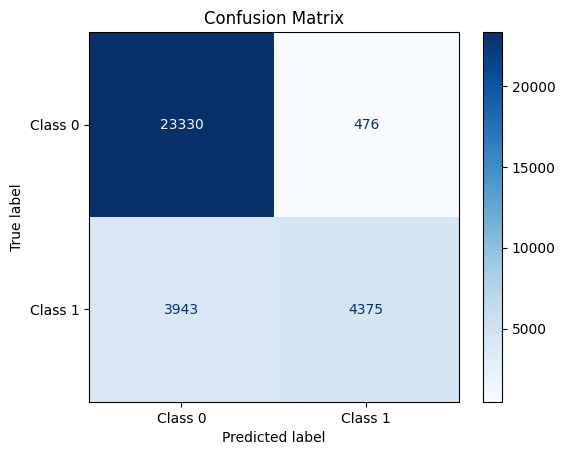

0.7325093150138855

In [23]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_predictions.extend(outputs.cpu().numpy())

# Flatten the predictions
val_predictions = [p[0] for p in val_predictions]
print("Validation predictions obtained.")

from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions))